### PNL Analisis de Sentimientos 

In [54]:
#!pip install wordcloud

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk, re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

Vamos a realizar analisis de sentimientos con una libreria llamada nltk con un modelo llamado SentimentIntensityAnalyzer para despues compararlo con  la biblioteca transformers de Hugging Face, que proporciona modelos preentrenados para el procesamiento del lenguaje natural.

Para este ejemplo, utilizaremos el modelo BETO (Bidirectional Encoder Representations from Transformers for Spanish) de la biblioteca transformers. 

Para posteriormente entranar un modelo y probarlo

#### Proceso a seguir para analisis mediante NLTK Y BETO

- Ideas clave — Estos son los pasos clave que seguiremos para descubrir información de los tweets diarios

- Importar las bibliotecas necesarias
- Cargar y explorar el conjunto de datos
- Limpiar y preparar los datos para el análisis
- Identificar el sentimiento público
- Identificar las palabras y frases más comunes utilizadas en los tweets
- Concluir el análisis

In [56]:
df = pd.read_csv('tweets.csv')
df

,usuario,tweet
0,['lopezdoriga'],"Joaquín López-Dóriga\n@lopezdoriga\n·\n10 jun.\nEl que no se iba a meter en el proceso interno de Morena dijo que cualquiera de las 'corcholatas' es garantía de continuidad de la 4T.\n\nhttps://bit.ly/43s8bJY\n149\n83\n300\n36,4 mil"
1,['Pajaropolitico'],"Animal Político\n@Pajaropolitico\n·\n10 jun.\n#OJO | Páginas en Facebook que promocionan a las ‘corcholatas’ de Morena de cara a las elecciones de 2024 acumulan desde 2022 un gasto de al menos 5 millones de pesos en anuncios para amplificar su contenido.\nanimalpolitico.com\nElección 2024: Gastan 5 mdp en promoción de 'corcholatas'\nPáginas en Facebook promocionan a las ‘corcholatas’ de Morena de cara a las elecciones de 2024. Acumulan un gasto de 5 millones de pesos.\n7\n186\n266\n19,7 mil"
2,['beltrandelrio'],"Pascal\n@beltrandelrio\n·\n42min\nEstá previsto que entre las reglas que al rato “definirá” el Consejo Nacional de Morena (entrecomillo el verbo porque la definición ya la hizo YSQ), estará que el 2o y 3er lugar de la encuesta entre corcholatas serán los coordinadores de la bancada de senadores y diputados (1/3)\n16\n106\n342\n25,7 mil\nMostrar este hilo"
3,"['Pajaropolitico', 'ElSabuesoAP']","Animal Político\n@Pajaropolitico\n·\n9 jun.\n#HoyEnAnimal | ¡Grr! La naricita de \n@ElSabuesoAP\n descubrió que páginas en Facebook que promocionan a las ‘corcholatas’ de Morena acumulan desde 2022 un gasto de al menos 5 millones de pesos en anuncios para amplificar su contenido.\nanimalpolitico.com\nElección 2024: Gastan 5 mdp en promoción de 'corcholatas'\nPáginas en Facebook promocionan a las ‘corcholatas’ de Morena de cara a las elecciones de 2024. Acumulan un gasto de 5 millones de pesos.\n5\n104\n179\n13,3 mil"
4,['StepLavalle'],Stephany Lavalle\n@StepLavalle\n·\n6 jun.\nAMLO CENÓ HOY CON LAS CORCHOLATAS DE MORENA\n#amlo #AMLOElMejorPresidenteDelMundo #AMLOvers #obrador #Claudia #MarceloEbrard #adanaugusto #noroña #NoroñaEsPueblo #ricardomonreal\n21\n67\n325\n8.648
...,...,...
92,"['CentralEq', 'Spreaker']","Central Equilibrio\n@CentralEq\n·\n8 jun.\n New Podcast! ""Primera emisión | 08 Junio 2023"" on \n@Spreaker\n #4t #adrianabraniff #aliados #centralfm #centrallive #colmex #corcholatas #diputados #elecciones #guadalupeacosta #morena #oposicion #pedroferriz #presidencia #primarias #reynaldoortega\nspreaker.com\nPrimera emisión | 08 Junio 2023\nXóchitl Gálvez Senadora del PAN comenta sobre la resolución en la que un juez le otorga el derecho de réplica en la mañanera, Guadalupe Acosta Naranjo nos habla de las pautas a seguir por la sociedad\n2\n2\n252"
93,['Afuegolentonews'],"A Fuego Lento Noticias\n@Afuegolentonews\n·\n9 jun.\n#Opinión| Ruta 2024: #Ebrard fractura a #Morena\n\nEl anuncio anticipado de su salida de la SRE movió la agenda de Morena, la de su dirigencia nacional y las otras corcholatas, provocando enojos y reclamos\n\nPara más información:\nafuegolentonoticias.com\nRuta 2024: Ebrad fractura a Morena\nEl anuncio anticipado de su salida de la SRE movió la agenda de Morena, la de su dirigencia nacional y las otras corcholatas, provocando enojos y reclamos\n1\n2\n37"
94,"['Jjlopez_almejo', 'lopezobrador_', 'Polemista4T']","Jesús López Almejo\n@Jjlopez_almejo\n·\n5 jun.\nQué vergüenza de candidato. En #Coahuila se pintó el escenario que le puede suceder a #Morena en México cuando termine el efecto \n@lopezobrador_\n \nEste tipo de candidatos, al que ni las corcholatas pudieron hacer que compitiera decentemente, deben evitarse en adelante. Aviso\nPolemista 4T\n@Polemista4T\n·\n4 jun.\n#LAMENTABLE\n Armando Guadiana reconoce que no denunció en su campaña la corrupción de Manolo Jiménez del PRI porque es amigo de él y de su familia\n\n Además dice que no volverá pronto al Senado porque se va de vacaciones a España para ver corridas de toros\n\n#Coahuila\n37\n159\n374\n13 mil"
95,['VivoNoticiasMX'],"Vivo Noticias\n@VivoNoticiasMX\n·\n23h\nHay acuerdo entre 'corcholatas', adelanta Sheinbaum\n\nEste domingo, se realizará el Consejo Po

In [57]:
#df = df.drop(['Unnamed: 0', 'Date', 'User', 'likeCount', 'replyCount', 'retweetCount', 'location'], axis=1)
df = df.drop(['usuario',], axis=1)
df

,tweet
0,"Joaquín López-Dóriga\n@lopezdoriga\n·\n10 jun.\nEl que no se iba a meter en el proceso interno de Morena dijo que cualquiera de las 'corcholatas' es garantía de continuidad de la 4T.\n\nhttps://bit.ly/43s8bJY\n149\n83\n300\n36,4 mil"
1,"Animal Político\n@Pajaropolitico\n·\n10 jun.\n#OJO | Páginas en Facebook que promocionan a las ‘corcholatas’ de Morena de cara a las elecciones de 2024 acumulan desde 2022 un gasto de al menos 5 millones de pesos en anuncios para amplificar su contenido.\nanimalpolitico.com\nElección 2024: Gastan 5 mdp en promoción de 'corcholatas'\nPáginas en Facebook promocionan a las ‘corcholatas’ de Morena de cara a las elecciones de 2024. Acumulan un gasto de 5 millones de pesos.\n7\n186\n266\n19,7 mil"
2,"Pascal\n@beltrandelrio\n·\n42min\nEstá previsto que entre las reglas que al rato “definirá” el Consejo Nacional de Morena (entrecomillo el verbo porque la definición ya la hizo YSQ), estará que el 2o y 3er lugar de la encuesta entre corcholatas serán los coordinadores de la bancada de senadores y diputados (1/3)\n16\n106\n342\n25,7 mil\nMostrar este hilo"
3,"Animal Político\n@Pajaropolitico\n·\n9 jun.\n#HoyEnAnimal | ¡Grr! La naricita de \n@ElSabuesoAP\n descubrió que páginas en Facebook que promocionan a las ‘corcholatas’ de Morena acumulan desde 2022 un gasto de al menos 5 millones de pesos en anuncios para amplificar su contenido.\nanimalpolitico.com\nElección 2024: Gastan 5 mdp en promoción de 'corcholatas'\nPáginas en Facebook promocionan a las ‘corcholatas’ de Morena de cara a las elecciones de 2024. Acumulan un gasto de 5 millones de pesos.\n5\n104\n179\n13,3 mil"
4,Stephany Lavalle\n@StepLavalle\n·\n6 jun.\nAMLO CENÓ HOY CON LAS CORCHOLATAS DE MORENA\n#amlo #AMLOElMejorPresidenteDelMundo #AMLOvers #obrador #Claudia #MarceloEbrard #adanaugusto #noroña #NoroñaEsPueblo #ricardomonreal\n21\n67\n325\n8.648
...,...
92,"Central Equilibrio\n@CentralEq\n·\n8 jun.\n New Podcast! ""Primera emisión | 08 Junio 2023"" on \n@Spreaker\n #4t #adrianabraniff #aliados #centralfm #centrallive #colmex #corcholatas #diputados #elecciones #guadalupeacosta #morena #oposicion #pedroferriz #presidencia #primarias #reynaldoortega\nspreaker.com\nPrimera emisión | 08 Junio 2023\nXóchitl Gálvez Senadora del PAN comenta sobre la resolución en la que un juez le otorga el derecho de réplica en la mañanera, Guadalupe Acosta Naranjo nos habla de las pautas a seguir por la sociedad\n2\n2\n252"
93,"A Fuego Lento Noticias\n@Afuegolentonews\n·\n9 jun.\n#Opinión| Ruta 2024: #Ebrard fractura a #Morena\n\nEl anuncio anticipado de su salida de la SRE movió la agenda de Morena, la de su dirigencia nacional y las otras corcholatas, provocando enojos y reclamos\n\nPara más información:\nafuegolentonoticias.com\nRuta 2024: Ebrad fractura a Morena\nEl anuncio anticipado de su salida de la SRE movió la agenda de Morena, la de su dirigencia nacional y las otras corcholatas, provocando enojos y reclamos\n1\n2\n37"
94,"Jesús López Almejo\n@Jjlopez_almejo\n·\n5 jun.\nQué vergüenza de candidato. En #Coahuila se pintó el escenario que le puede suceder a #Morena en México cuando termine el efecto \n@lopezobrador_\n \nEste tipo de candidatos, al que ni las corcholatas pudieron hacer que compitiera decentemente, deben evitarse en adelante. Aviso\nPolemista 4T\n@Polemista4T\n·\n4 jun.\n#LAMENTABLE\n Armando Guadiana reconoce que no denunció en su campaña la corrupción de Manolo Jiménez del PRI porque es amigo de él y de su familia\n\n Además dice que no volverá pronto al Senado porque se va de vacaciones a España para ver corridas de toros\n\n#Coahuila\n37\n159\n374\n13 mil"
95,"Vivo Noticias\n@VivoNoticiasMX\n·\n23h\nHay acuerdo entre 'corcholatas', adelanta Sheinbaum\n\nEste domingo, se realizará el Consejo Político Nacional de Morena. Estarán presentes sus aspirantes a la presidencia de México\n\nhttps://vivonoticias.mx/notas/nota.php?id_n=89392…\n48"


In [58]:
df.isnull().sum()

tweet    0
dtype: int64

In [59]:
#nltk.download('vader_lexicon')

In [60]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#nltk.download('stopwords')
#nltk.download('punkt')


# Función de preprocesamiento de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    
    # Remover números
    text = re.sub(r'\d+', '', text)
    
    # Remover signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenización
    tokens = word_tokenize(text)
    
    # Remover palabras vacías (stop words)
    stop_words = set(stopwords.words('spanish'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Unir tokens en un solo texto
    preprocessed_text = ' '.join(tokens)

    #remover urls y reemplazar por la palabra URL
    preprocessed_text = re.sub(r'https?:\/\/\S+', 'URL', preprocessed_text)
    
    return preprocessed_text



In [61]:
# Aplicar preprocesamiento a la columna 'texto'
df['tweet'] = df['tweet'].apply(preprocess_text)

# Imprimir el DataFrame con el texto preprocesado
print(df)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                 tweet
0                                                                                                                                                                                                                                                                                                                         joaquín lópezdóriga lopezdoriga · jun iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil
1                                                                                         

In [62]:
df

,tweet
0,joaquín lópezdóriga lopezdoriga · jun iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil
1,animal político pajaropolitico · jun ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo
3,animal político pajaropolitico · jun hoyenanimal ¡grr naricita elsabuesoap descubrió páginas facebook promocionan ‘ corcholatas ’ morena acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil
4,stephany lavalle steplavalle · jun amlo cenó hoy corcholatas morena amlo amloelmejorpresidentedelmundo amlovers obrador claudia marceloebrard adanaugusto noroña noroñaespueblo ricardomonreal
...,...
92,central equilibrio centraleq · jun new podcast primera emisión junio on spreaker t adrianabraniff aliados centralfm centrallive colmex corcholatas diputados elecciones guadalupeacosta morena oposicion pedroferriz presidencia primarias reynaldoortega spreakercom primera emisión junio xóchitl gálvez senadora pan comenta resolución juez otorga derecho réplica mañanera guadalupe acosta naranjo habla pautas seguir sociedad
93,fuego lento noticias afuegolentonews · jun opinión ruta ebrard fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos información afuegolentonoticiascom ruta ebrad fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos
94,jesús lópez almejo jjlopezalmejo · jun vergüenza candidato coahuila pintó escenario puede suceder morena méxico termine efecto lopezobrador tipo candidatos corcholatas pudieron hacer compitiera decentemente deben evitarse adelante aviso polemista t polemistat · jun lamentable armando guadiana reconoce denunció campaña corrupción manolo jiménez pri amigo familia además dice volverá pronto senado va vacaciones españa ver corridas toros coahuila mil
95,vivo noticias vivonoticiasmx · h acuerdo corcholatas adelanta sheinbaum domingo realizará consejo político nacional morena presentes aspirantes presidencia méxico httpsvivonoticiasmxnotasnotaphpidn…


Ahora que nuestros tweets están impecables, es hora de usarlos para tener una idea de los sentimientos de las personas mediante el uso para calcular la puntuación de polaridad de cada tweet. Esto nos ayudará a averiguar si los tweets son en su mayoría positivos, negativos o neutrales y nos dará una idea de lo que la gente está diciendo sobre el tema.SentimentIntensityAnalyzer

In [63]:
for index, row in df['tweet'].iteritems():
  score = SentimentIntensityAnalyzer().polarity_scores(row)
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  if neg > pos:
    df.loc[index, 'Sentiment'] = 'Negative'
  elif pos > neg:
    df.loc[index, 'Sentiment'] = 'Positive'
  else:
    df.loc[index, 'Sentiment'] = 'Neutral'

df

C:\Users\Adolfo\AppData\Local\Temp\ipykernel_9400\1534747813.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, row in df['tweet'].iteritems():


,tweet,Sentiment
0,joaquín lópezdóriga lopezdoriga · jun iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,Neutral
1,animal político pajaropolitico · jun ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutral
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,Neutral
3,animal político pajaropolitico · jun hoyenanimal ¡grr naricita elsabuesoap descubrió páginas facebook promocionan ‘ corcholatas ’ morena acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutral
4,stephany lavalle steplavalle · jun amlo cenó hoy corcholatas morena amlo amloelmejorpresidentedelmundo amlovers obrador claudia marceloebrard adanaugusto noroña noroñaespueblo ricardomonreal,Neutral
...,...,...
92,central equilibrio centraleq · jun new podcast primera emisión junio on spreaker t adrianabraniff aliados centralfm centrallive colmex corcholatas diputados elecciones guadalupeacosta morena oposicion pedroferriz presidencia primarias reynaldoortega spreakercom primera emisión junio xóchitl gálvez senadora pan comenta resolución juez otorga derecho réplica mañanera guadalupe acosta naranjo habla pautas seguir sociedad,Neutral
93,fuego lento noticias afuegolentonews · jun opinión ruta ebrard fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos información afuegolentonoticiascom ruta ebrad fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos,Neutral
94,jesús lópez almejo jjlopezalmejo · jun vergüenza candidato coahuila pintó escenario puede suceder morena méxico termine efecto lopezobrador tipo candidatos corcholatas pudieron hacer compitiera decentemente deben evitarse adelante aviso polemista t polemistat · jun lamentable armando guadiana reconoce denunció campaña corrupción manolo jiménez pri amigo familia además dice volverá pronto senado va vacaciones españa ver corridas toros coahuila mil,Negative
95,vivo noticias vivonoticiasmx · h acuerdo corcholatas adelanta sheinbaum domingo realizará consejo político nacional morena presentes aspirantes presidencia méxico httpsvivonoticiasmxnotasnotaphpidn…,Neutral


In [64]:
#visualizar texto completo del tweet y su sentimiento
pd.set_option('display.max_colwidth', None)

In [65]:
def count_tp_in_column(data,feature):
  total = data.loc[:,feature].value_counts(dropna=False)
  percentage = data.loc[:,feature].value_counts(dropna=False, normalize=True)*100
  return pd.concat([total, round(percentage,2)], axis=1, keys=['Total', 'Percentage'])

tp = count_tp_in_column(df,'Sentiment')
tp

,Total,Percentage
Neutral,86,88.66
Positive,8,8.25
Negative,3,3.09


<module 'matplotlib.pyplot' from 'c:\\Users\\Adolfo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

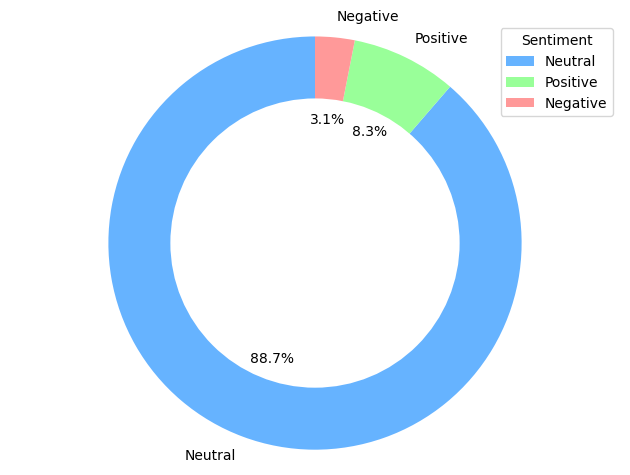

In [66]:
labels = tp.index
sizes = tp['Percentage']
colors = ['#66b3ff','#99ff99','#ff9999']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.legend(title='Sentiment')
plt

### Palabras más utilizadas 

<module 'matplotlib.pyplot' from 'c:\\Users\\Adolfo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

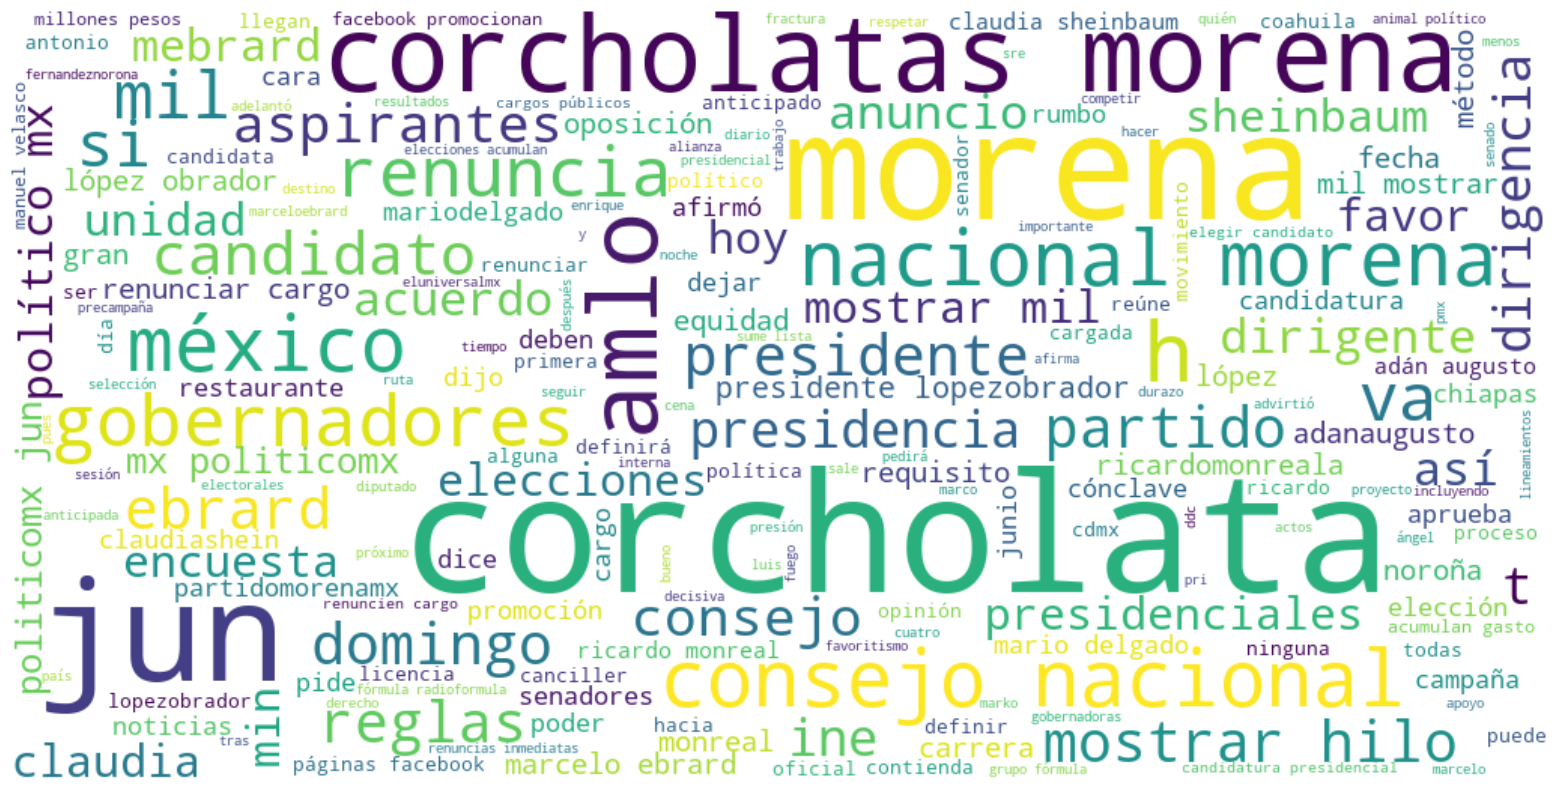

In [67]:
all_tweets = " ".join(tweet for tweet in df['tweet'])

wordcloud = WordCloud(width=1024, height=512, random_state=21, max_font_size=110, background_color='white').generate(all_tweets)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt

### tweets con solo sentimientos positivos



<module 'matplotlib.pyplot' from 'c:\\Users\\Adolfo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

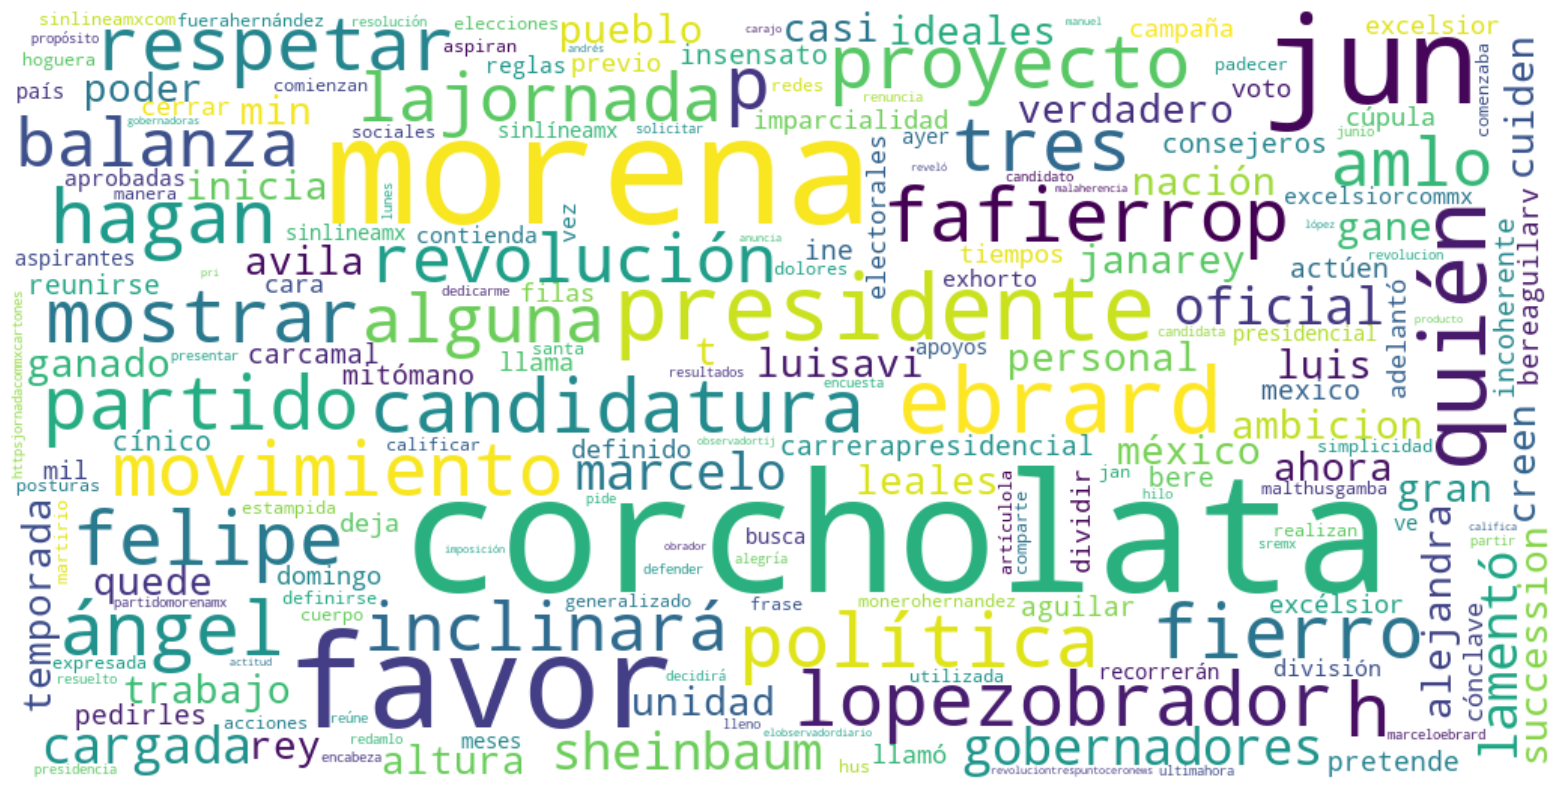

In [68]:
all_positive_tweets = " ".join(tweet for tweet in df[df['Sentiment'] == 'Positive']['tweet'])

wordcloud = WordCloud(width=1024, height=512, random_state=21, max_font_size=110, background_color='white').generate(all_positive_tweets)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt

### y esos tweets con sentimientos negativos.

<module 'matplotlib.pyplot' from 'c:\\Users\\Adolfo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

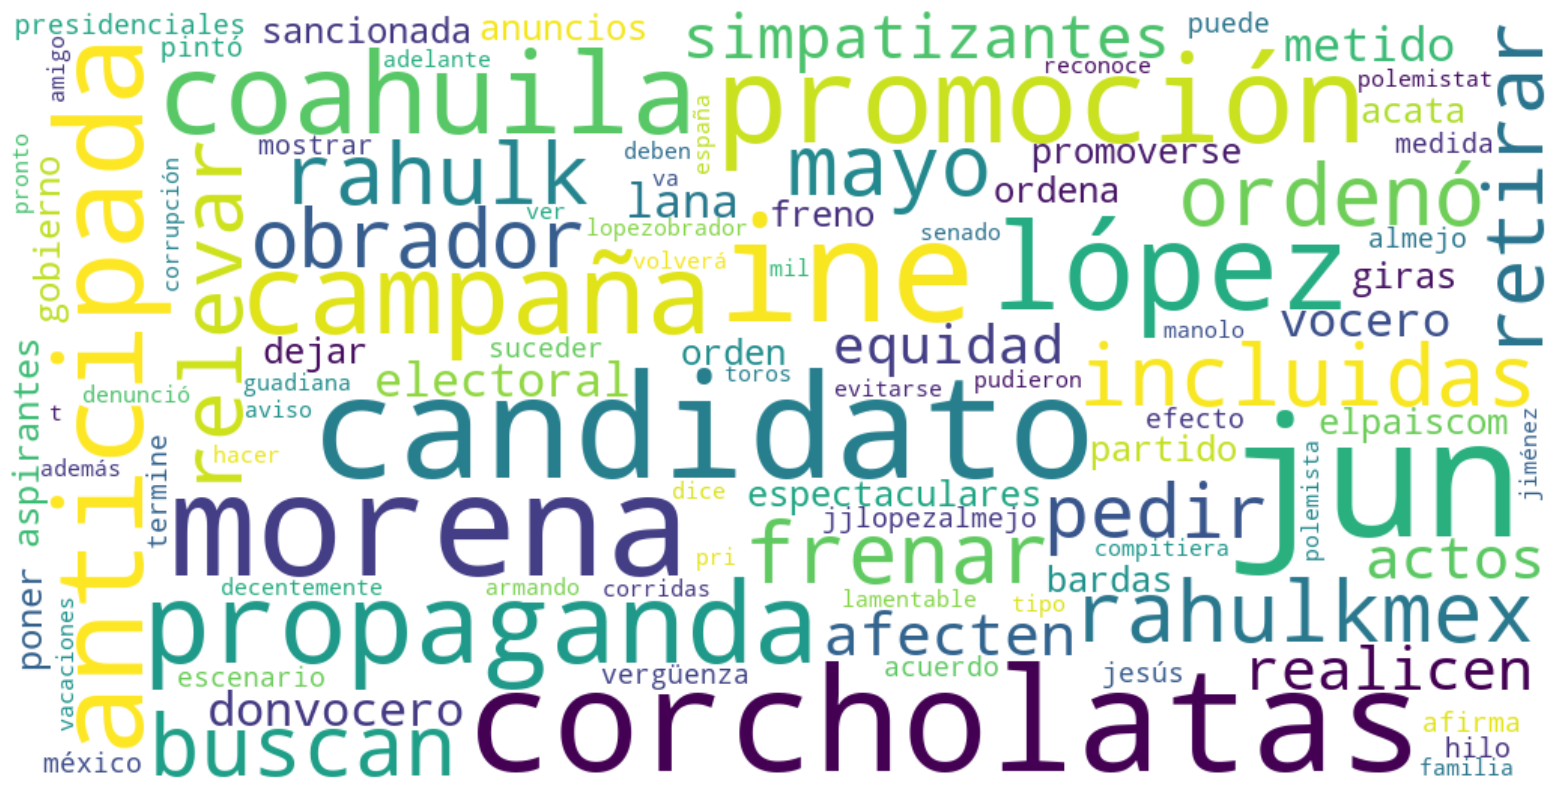

In [69]:
all_negative_tweets = " ".join(tweet for tweet in df[df['Sentiment'] == 'Negative']['tweet'])

wordcloud = WordCloud(width=1024, height=512, random_state=21, max_font_size=110, background_color='white').generate(all_negative_tweets)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt

In [70]:
df.head(3)

,tweet,Sentiment
0,joaquín lópezdóriga lopezdoriga · jun iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,Neutral
1,animal político pajaropolitico · jun ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutral
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,Neutral


In [71]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

# Cargar el modelo y el tokenizador
model_name = "finiteautomata/beto-sentiment-analysis"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Definir una función para realizar el análisis de sentimientos
def analyze_sentiment(text):
    # Tokenizar el texto de entrada
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    # Obtener las predicciones de sentimiento (etiquetas y probabilidades)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).detach().numpy()[0]
    sentiment_labels = ['Negativo', 'Neutro', 'Positivo']
    predicted_label = np.argmax(probabilities)
    predicted_sentiment = sentiment_labels[predicted_label]
    predicted_probability = probabilities[predicted_label]

    # Devolver los resultados del análisis
    results = {
        'Texto': text,
        'Sentimiento': predicted_sentiment,
        'Probabilidad': predicted_probability
    }
    return results

In [72]:
#acceder a Texto y Sentimiento dentro de results
results = analyze_sentiment(df['tweet'][0])
results['Texto']

'joaquín lópezdóriga lopezdoriga · jun iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil'

In [73]:
df_BETO = []
for x in df['tweet']:
  print(analyze_sentiment(x))
  tabla = {
      'Tweet': analyze_sentiment(x)['Texto'],
      'Sentiment': analyze_sentiment(x)['Sentimiento'],
  }
  df_BETO.append(tabla)
  

{'Texto': 'joaquín lópezdóriga lopezdoriga · jun iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil', 'Sentimiento': 'Neutro', 'Probabilidad': 0.9971316}
{'Texto': 'animal político pajaropolitico · jun ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil', 'Sentimiento': 'Neutro', 'Probabilidad': 0.93325114}
{'Texto': 'pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo', 'Sentimiento': 'Neutro', 'Probabilidad': 0.99717283}
{'Texto': 'animal político pajaropolitico · jun hoyenanimal ¡grr naricita elsabuesoap descubrió páginas facebook

In [74]:
dataframe = pd.DataFrame(df_BETO)

<module 'matplotlib.pyplot' from 'c:\\Users\\Adolfo\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

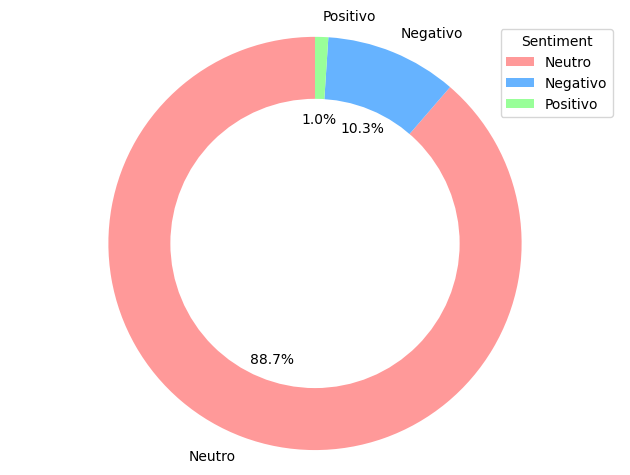

In [75]:
tp = count_tp_in_column(dataframe,'Sentiment')
tp

labels = tp.index
sizes = tp['Percentage']
colors = ['#ff9999','#66b3ff','#99ff99']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.legend(title='Sentiment')
plt

In [76]:
dataframe

,Tweet,Sentiment
0,joaquín lópezdóriga lopezdoriga · jun iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,Neutro
1,animal político pajaropolitico · jun ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutro
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,Neutro
3,animal político pajaropolitico · jun hoyenanimal ¡grr naricita elsabuesoap descubrió páginas facebook promocionan ‘ corcholatas ’ morena acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutro
4,stephany lavalle steplavalle · jun amlo cenó hoy corcholatas morena amlo amloelmejorpresidentedelmundo amlovers obrador claudia marceloebrard adanaugusto noroña noroñaespueblo ricardomonreal,Neutro
...,...,...
92,central equilibrio centraleq · jun new podcast primera emisión junio on spreaker t adrianabraniff aliados centralfm centrallive colmex corcholatas diputados elecciones guadalupeacosta morena oposicion pedroferriz presidencia primarias reynaldoortega spreakercom primera emisión junio xóchitl gálvez senadora pan comenta resolución juez otorga derecho réplica mañanera guadalupe acosta naranjo habla pautas seguir sociedad,Neutro
93,fuego lento noticias afuegolentonews · jun opinión ruta ebrard fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos información afuegolentonoticiascom ruta ebrad fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos,Negativo
94,jesús lópez almejo jjlopezalmejo · jun vergüenza candidato coahuila pintó escenario puede suceder morena méxico termine efecto lopezobrador tipo candidatos corcholatas pudieron hacer compitiera decentemente deben evitarse adelante aviso polemista t polemistat · jun lamentable armando guadiana reconoce denunció campaña corrupción manolo jiménez pri amigo familia además dice volverá pronto senado va vacaciones españa ver corridas toros coahuila mil,Neutro
95,vivo noticias vivonoticiasmx · h acuerdo corcholatas adelanta sheinbaum domingo realizará consejo político nacional morena presentes aspirantes presidencia méxico httpsvivonoticiasmxnotasnotaphpidn…,Neutro


In [77]:
tuits_para_entrenar = [
    {
        'texto': 'Corcholatas de Morena siguen arriba en ranking presidencial; Noroña salta al cuarto lugar',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'La pelea dentro de morena por la candidatura a la presidencia en 2024 ya comenzó',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Buena idea organizarse para que no se repita la historia de Morena en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Morena se desmorona y se desangra por la corrupción y la ambición de poder',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Morena mantiene ventaja en preferencias electorales rumbo a 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'A Morena le urge un cambio de dirigencia',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Andrés Manuel López Obrador, presidente de México, aseguró que Morena no se va a dividir',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Este es el momento de Morena para demostrar que es un partido diferente',
        'sentimiento': 'Positivo'
    },
    {'texto': 'Este fin de semana se determinara el futuro de Morena',
        'sentimiento': 'Neutro'
     },
    {
        'texto': 'Ninguno de los aspirantes a la presidencia de Morena tiene el perfil para gobernar',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'El canciller Marcelo Ebrard aseguró que no se va a separar de su cargo para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Marcelo Ebrard , renuncio a su cargo como canciller para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {
        'texto': 'Sheinbaum, Ebrard y Delgado, los favoritos para la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Mario delgado, renuncio a su cargo como diputado para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {
        'texto': 'Pelea por la candidatura de Morena a la presidencia en 2024, se calienta',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Que chingue a su madre Morena',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Mexico unido por Morena',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Noroña se registra como precandidato de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {
        'texto': 'Corcholatas de Morena siguen arriba en ranking presidencial; Noroña salta al cuarto lugar',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'La pelea dentro de morena por la candidatura a la presidencia en 2024 ya comenzó',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Buena idea organizarse para que no se repita la historia de Morena en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Morena se desmorona y se desangra por la corrupción y la ambición de poder',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Morena mantiene ventaja en preferencias electorales rumbo a 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'A Morena le urge un cambio de dirigencia',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Andrés Manuel López Obrador, presidente de México, aseguró que Morena no se va a dividir',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Este es el momento de Morena para demostrar que es un partido diferente',
        'sentimiento': 'Positivo'
    },
    {'texto': 'Este fin de semana se determinara el futuro de Morena',
        'sentimiento': 'Neutro'
     },
    {
        'texto': 'Ninguno de los aspirantes a la presidencia de Morena tiene el perfil para gobernar',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'El canciller Marcelo Ebrard aseguró que no se va a separar de su cargo para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Marcelo Ebrard , renuncio a su cargo como canciller para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {
        'texto': 'Sheinbaum, Ebrard y Delgado, los favoritos para la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Mario delgado, renuncio a su cargo como diputado para buscar la candidatura de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {
        'texto': 'Pelea por la candidatura de Morena a la presidencia en 2024, se calienta',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Que chingue a su madre Morena',
        'sentimiento': 'Negativo'
    },
    {
        'texto': 'Mexico unido por Morena',
        'sentimiento': 'Positivo'
    },
    {
        'texto': 'Noroña se registra como precandidato de Morena a la presidencia en 2024',
        'sentimiento': 'Neutro'
    },
    {'texto': 'El proceso de selección del candidato de Morena será crucial para el futuro del partido',
        'sentimiento': 'Neutro'},
    {'texto': 'Espero que los precandidatos de Morena presenten planes sólidos para abordar los problemas de seguridad en el país', 'sentimiento': 'Positivo'},
    {'texto': 'Noroña ha sido una figura controvertida, su posible candidatura podría generar división dentro de Morena',
        'sentimiento': 'Negativo'},
    {'texto': 'Morena necesita un candidato que pueda generar confianza y unidad en el partido',
        'sentimiento': 'Positivo'},
    {'texto': 'Esperemos que los precandidatos de Morena se enfoquen en propuestas realistas y viables para el desarrollo económico', 'sentimiento': 'Positivo'},
    {'texto': 'La contienda interna de Morena refleja la diversidad de ideas y opiniones dentro del partido',
        'sentimiento': 'Neutro'},
    {'texto': 'Ebrard ha demostrado habilidades diplomáticas, eso podría ser valioso para las relaciones internacionales de México', 'sentimiento': 'Positivo'},
    {'texto': 'Delgado ha trabajado en la promoción de la agenda legislativa de Morena, eso podría respaldar su candidatura', 'sentimiento': 'Positivo'},
    {'texto': 'Es importante que Morena elija a un candidato capaz de impulsar políticas públicas efectivas',
        'sentimiento': 'Positivo'},
    {'texto': 'No veo a ninguno de los precandidatos de Morena como una opción sólida y convincente para la presidencia',
        'sentimiento': 'Negativo'},
    {'texto': 'Sheinbaum ha sido una líder destacada en la Ciudad de México, eso podría fortalecer su candidatura en Morena', 'sentimiento': 'Positivo'},
    {'texto': 'Noroña ha sido una voz crítica dentro de Morena, su candidatura podría atraer a los seguidores de posturas más radicales', 'sentimiento': 'Positivo'},
    {'texto': 'Espero que los precandidatos de Morena tengan una visión clara para abordar los desafíos del cambio climático', 'sentimiento': 'Positivo'},
    {'texto': 'La unidad y cohesión interna de Morena serán fundamentales para el éxito en las próximas elecciones',
        'sentimiento': 'Positivo'},
    {'texto': 'No encuentro a ninguno de los precandidatos de Morena como un líder carismático y capaz de movilizar a las masas', 'sentimiento': 'Negativo'},
    {'texto': 'Sheinbaum ha implementado políticas públicas innovadoras en la Ciudad de México, eso podría impulsar su candidatura a nivel nacional', 'sentimiento': 'Positivo'},
    {'texto': 'Esperemos que la contienda interna de Morena se lleve a cabo de manera justa y transparente',
        'sentimiento': 'Positivo'},
    {'texto': 'Algunos precandidatos de Morena han sido señalados por presuntos actos de corrupción, eso podría afectar su imagen', 'sentimiento': 'Negativo'},
    {'texto': 'Morena necesita un candidato que pueda promover la inclusión social y combatir la desigualdad en el país',
        'sentimiento': 'Positivo'},
    {'texto': 'Espero que los precandidatos de Morena presenten soluciones efectivas para mejorar el sistema de salud en México', 'sentimiento': 'Positivo'},
    {'texto': 'El liderasgo de Sheinbaum en la Ciudad de México la posiciona como una fuerte contendiente para la candidatura presidensial de Morena.', 'sentimiento': 'Positivo'},
{'texto': 'La polarisación interna en Morena refleja la diversidad de opiniones y enfoques dentro del partído.', 'sentimiento': 'Neutro'},
{'texto': 'Noroha ha generado contoversia en el pasado, lo cual podría afectar su viavilidad como candidato de Morena.', 'sentimiento': 'Negativo'},
{'texto': 'Espero que los precandidatos de Morena presenten propuestas sólidas y realístas para impulsar el desarrollo económico del país.', 'sentimiento': 'Positivo'},
{'texto': 'La contienda interna en Morena será crucíal para definir el rumbo del partido y sus posibilidades en las elecciones.', 'sentimiento': 'Neutro'},
{'texto': 'Ebrard ha demostrado habilidades diplomáticas y esperiencia en asuntos internacionales, lo cual podría fortalecer su candidatura.', 'sentimiento': 'Positivo'},
{'texto': 'Delgado ha trabajado en el fortalecimiento de la estructura partidária de Morena, lo cual podría beneficiar su aspíración presidensial.', 'sentimiento': 'Positivo'},
{'texto': 'Espero que Morena selecsione a un candidato con visión de largo plazo y compromiso con el bienestar de la población.', 'sentimiento': 'Positivo'},
{'texto': 'La elección del candidato de Morena definirá el futuro del partido y su capacidad para mantener el apoyo popular.', 'sentimiento': 'Neutro'},
{'texto': 'No veo a ninguno de los precandidatos de Morena como líderes carismáticos capases de unir al país.', 'sentimiento': 'Negativo'},
{'texto': 'Sheinbaum ha logrado avanses significativos en materia de movilidad y medio ambíente en la Ciudad de México.', 'sentimiento': 'Positivo'},
{'texto': 'Noroha ha sido una figúra polémica, lo cual podría afectar su imagen y apoyo dentro y fuera de Morena.', 'sentimiento': 'Negativo'},
{'texto': 'Espero que los precandidatos de Morena presenten planes claros para abordar los desafíos de seguridád y justícia en el país.', 'sentimiento': 'Positivo'},
{'texto': 'La unidad interna de Morena será clave para enfrentar los retos electorales y mantener el apollo ciudadano.', 'sentimiento': 'Positivo'},
{'texto': 'No encuentro a ninguno de los precandidatos de Morena como opciones convincentes y sálidas para el país.', 'sentimiento': 'Negativo'},



]


In [78]:
df_tuits_para_entrenar = pd.DataFrame(tuits_para_entrenar)

In [79]:
df_tuits_para_entrenar

,texto,sentimiento
0,Corcholatas de Morena siguen arriba en ranking presidencial; Noroña salta al cuarto lugar,Positivo
1,La pelea dentro de morena por la candidatura a la presidencia en 2024 ya comenzó,Negativo
2,Buena idea organizarse para que no se repita la historia de Morena en 2024,Positivo
3,Morena se desmorona y se desangra por la corrupción y la ambición de poder,Negativo
4,Morena mantiene ventaja en preferencias electorales rumbo a 2024,Positivo
...,...,...
66,Sheinbaum ha logrado avanses significativos en materia de movilidad y medio ambíente en la Ciudad de México.,Positivo
67,"Noroha ha sido una figúra polémica, lo cual podría afectar su imagen y apoyo dentro y fuera de Morena.",Negativo
68,Espero que los precandidatos de Morena presenten planes claros para abordar los desafíos de seguridád y justícia en el país.,Positivo
69,La unidad interna de Morena será clave para enfrentar los retos electorales y mantener el apollo ciudadano.,Positivo


In [80]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')


# Función de preprocesamiento de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    
    # Remover números
    text = re.sub(r'\d+', '', text)
    
    # Remover signos de puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenización
    tokens = word_tokenize(text)
    
    # Remover palabras vacías (stop words)
    stop_words = set(stopwords.words('spanish'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Unir tokens en un solo texto
    preprocessed_text = ' '.join(tokens)

    #remover urls y reemplazar por la palabra URL
    preprocessed_text = re.sub(r'https?:\/\/\S+', 'URL', preprocessed_text)
    
    return preprocessed_text

# Aplicar preprocesamiento a la columna 'texto'
df_tuits_para_entrenar['texto'] = df_tuits_para_entrenar['texto'].apply(preprocess_text)

# Imprimir el DataFrame con el texto preprocesado
print(df_tuits_para_entrenar)


                                                                                           texto  \
0                corcholatas morena siguen arriba ranking presidencial noroña salta cuarto lugar   
1                                            pelea dentro morena candidatura presidencia comenzó   
2                                                  buena idea organizarse repita historia morena   
3                                            morena desmorona desangra corrupción ambición poder   
4                                         morena mantiene ventaja preferencias electorales rumbo   
..                                                                                           ...   
66       sheinbaum logrado avanses significativos materia movilidad medio ambíente ciudad méxico   
67                         noroha sido figúra polémica podría afectar imagen apoyo dentro morena   
68  espero precandidatos morena presenten planes claros abordar desafíos seguridád justícia país   


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adolfo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adolfo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Con nuestro dataset validado vamos a probar como funciona con BETO

In [81]:
#!pip install accelerate -U

In [82]:
dataset = df_tuits_para_entrenar

In [83]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import joblib
import nltk
from nltk.tokenize import word_tokenize

# Esta es nuestra función de análisis que será utilizada en lugar de la función lambda
def tokenize(text):
    return text

# nltk.download('punkt')

dataset['texto_tokenizado'] = dataset['texto'].apply(word_tokenize)

# Pasamos nuestra nueva función de análisis a CountVectorizer
vectorizer = CountVectorizer(analyzer=tokenize)
X = vectorizer.fit_transform(dataset['texto_tokenizado'].tolist())

y = dataset['sentimiento'].map({'Negativo': 0, 'Positivo': 1, 'Neutro': 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

joblib.dump(model, 'model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

model = joblib.load('model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

def predict_sentiment(text):
    tokens = word_tokenize(text)
    features = vectorizer.transform([tokens])
    sentiment = model.predict(features)[0]
    return {0: 'Negativo', 1: 'Positivo', 2: 'Neutro'}[sentiment]


In [84]:
predicciones = []
for x in df['tweet']:
    tabla = {
        'Tweet': predict_sentiment(x),
    }
    predicciones.append(tabla)


In [85]:
#apilar predicciones en df con el nombre de Model_Sentiment
dataframe['Model_Sentiment'] = predicciones

dataframe

,Tweet,Sentiment,Model_Sentiment
0,joaquín lópezdóriga lopezdoriga · jun iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,Neutro,{'Tweet': 'Neutro'}
1,animal político pajaropolitico · jun ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutro,{'Tweet': 'Neutro'}
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,Neutro,{'Tweet': 'Neutro'}
3,animal político pajaropolitico · jun hoyenanimal ¡grr naricita elsabuesoap descubrió páginas facebook promocionan ‘ corcholatas ’ morena acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,Neutro,{'Tweet': 'Neutro'}
4,stephany lavalle steplavalle · jun amlo cenó hoy corcholatas morena amlo amloelmejorpresidentedelmundo amlovers obrador claudia marceloebrard adanaugusto noroña noroñaespueblo ricardomonreal,Neutro,{'Tweet': 'Positivo'}
...,...,...,...
92,central equilibrio centraleq · jun new podcast primera emisión junio on spreaker t adrianabraniff aliados centralfm centrallive colmex corcholatas diputados elecciones guadalupeacosta morena oposicion pedroferriz presidencia primarias reynaldoortega spreakercom primera emisión junio xóchitl gálvez senadora pan comenta resolución juez otorga derecho réplica mañanera guadalupe acosta naranjo habla pautas seguir sociedad,Neutro,{'Tweet': 'Neutro'}
93,fuego lento noticias afuegolentonews · jun opinión ruta ebrard fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos información afuegolentonoticiascom ruta ebrad fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos,Negativo,{'Tweet': 'Positivo'}
94,jesús lópez almejo jjlopezalmejo · jun vergüenza candidato coahuila pintó escenario puede suceder morena méxico termine efecto lopezobrador tipo candidatos corcholatas pudieron hacer compitiera decentemente deben evitarse adelante aviso polemista t polemistat · jun lamentable armando guadiana reconoce denunció campaña corrupción manolo jiménez pri amigo familia además dice volverá pronto senado va vacaciones españa ver corridas toros coahuila mil,Neutro,{'Tweet': 'Positivo'}
95,vivo noticias vivonoticiasmx · h acuerdo corcholatas adelanta sheinbaum domingo realizará consejo político nacional morena presentes aspirantes presidencia méxico httpsvivonoticiasmxnotasnotaphpidn…,Neutro,{'Tweet': 'Positivo'}


In [89]:
for x in dataframe['Sentiment']:
    if x == "Neutro":
        #reemplazar por 1 
        dataframe['Sentiment'] = dataframe['Sentiment'].replace(x, 2)
    elif x == "Positivo":
        #reemplazar por 2
        dataframe['Sentiment'] = dataframe['Sentiment'].replace(x, 0)
    elif x == "Negativo":
            #reemplazar por 0
            dataframe['Sentiment'] = dataframe['Sentiment'].replace(x, 1)

In [101]:
def convert_sentiment(sentiment):
    if sentiment['Tweet'] == 'Positivo':
        return 0
    elif sentiment['Tweet'] == 'Negativo':
        return 1
    elif sentiment['Tweet'] == 'Neutro':
        return 2

dataframe['Model_Sentiment'] = dataframe['Model_Sentiment'].apply(convert_sentiment)


In [102]:
dataframe

,Tweet,Sentiment,Model_Sentiment
0,joaquín lópezdóriga lopezdoriga · jun iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,2,2
1,animal político pajaropolitico · jun ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,2,2
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,2,2
3,animal político pajaropolitico · jun hoyenanimal ¡grr naricita elsabuesoap descubrió páginas facebook promocionan ‘ corcholatas ’ morena acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,2,2
4,stephany lavalle steplavalle · jun amlo cenó hoy corcholatas morena amlo amloelmejorpresidentedelmundo amlovers obrador claudia marceloebrard adanaugusto noroña noroñaespueblo ricardomonreal,2,0
...,...,...,...
92,central equilibrio centraleq · jun new podcast primera emisión junio on spreaker t adrianabraniff aliados centralfm centrallive colmex corcholatas diputados elecciones guadalupeacosta morena oposicion pedroferriz presidencia primarias reynaldoortega spreakercom primera emisión junio xóchitl gálvez senadora pan comenta resolución juez otorga derecho réplica mañanera guadalupe acosta naranjo habla pautas seguir sociedad,2,2
93,fuego lento noticias afuegolentonews · jun opinión ruta ebrard fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos información afuegolentonoticiascom ruta ebrad fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos,1,0
94,jesús lópez almejo jjlopezalmejo · jun vergüenza candidato coahuila pintó escenario puede suceder morena méxico termine efecto lopezobrador tipo candidatos corcholatas pudieron hacer compitiera decentemente deben evitarse adelante aviso polemista t polemistat · jun lamentable armando guadiana reconoce denunció campaña corrupción manolo jiménez pri amigo familia además dice volverá pronto senado va vacaciones españa ver corridas toros coahuila mil,2,0
95,vivo noticias vivonoticiasmx · h acuerdo corcholatas adelanta sheinbaum domingo realizará consejo político nacional morena presentes aspirantes presidencia méxico httpsvivonoticiasmxnotasnotaphpidn…,2,0


In [104]:
# Crear una nueva columna "datos_reales" inicializada con valores nulos
dataframe['datos_reales'] = None

# Iterar sobre el dataframe
for index, row in dataframe.iterrows():
    tweet = row['Tweet']
    # Solicitar entrada al usuario
    num = int(input("Introduce un número entero (0-2) para el tweet '{}': ".format(tweet)))
    
    # Verificar si el número está en el rango correcto
    while num < 0 or num > 2:
        print("Número inválido. Inténtalo de nuevo.")
        num = int(input("Introduce un número entero (0-2) para el tweet '{}': ".format(tweet)))
    
    # Asignar el número ingresado a la columna "datos_reales"
    dataframe.loc[index, 'datos_reales'] = num


In [106]:
#guardar en csv el dataframe
dataframe.to_csv('Primera_Comparacion.csv')

In [107]:
dataframe

,Tweet,Sentiment,Model_Sentiment,datos_reales
0,joaquín lópezdóriga lopezdoriga · jun iba meter proceso interno morena dijo cualquiera corcholatas garantía continuidad t httpsbitlysbjy mil,2,2,2
1,animal político pajaropolitico · jun ojo páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,2,2,1
2,pascal beltrandelrio · min previsto reglas rato “ definirá ” consejo nacional morena entrecomillo verbo definición hizo ysq er lugar encuesta corcholatas coordinadores bancada senadores diputados mil mostrar hilo,2,2,2
3,animal político pajaropolitico · jun hoyenanimal ¡grr naricita elsabuesoap descubrió páginas facebook promocionan ‘ corcholatas ’ morena acumulan gasto menos millones pesos anuncios amplificar contenido animalpoliticocom elección gastan mdp promoción corcholatas páginas facebook promocionan ‘ corcholatas ’ morena cara elecciones acumulan gasto millones pesos mil,2,2,1
4,stephany lavalle steplavalle · jun amlo cenó hoy corcholatas morena amlo amloelmejorpresidentedelmundo amlovers obrador claudia marceloebrard adanaugusto noroña noroñaespueblo ricardomonreal,2,0,2
...,...,...,...,...
92,central equilibrio centraleq · jun new podcast primera emisión junio on spreaker t adrianabraniff aliados centralfm centrallive colmex corcholatas diputados elecciones guadalupeacosta morena oposicion pedroferriz presidencia primarias reynaldoortega spreakercom primera emisión junio xóchitl gálvez senadora pan comenta resolución juez otorga derecho réplica mañanera guadalupe acosta naranjo habla pautas seguir sociedad,2,2,2
93,fuego lento noticias afuegolentonews · jun opinión ruta ebrard fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos información afuegolentonoticiascom ruta ebrad fractura morena anuncio anticipado salida sre movió agenda morena dirigencia nacional corcholatas provocando enojos reclamos,1,0,2
94,jesús lópez almejo jjlopezalmejo · jun vergüenza candidato coahuila pintó escenario puede suceder morena méxico termine efecto lopezobrador tipo candidatos corcholatas pudieron hacer compitiera decentemente deben evitarse adelante aviso polemista t polemistat · jun lamentable armando guadiana reconoce denunció campaña corrupción manolo jiménez pri amigo familia además dice volverá pronto senado va vacaciones españa ver corridas toros coahuila mil,2,0,1
95,vivo noticias vivonoticiasmx · h acuerdo corcholatas adelanta sheinbaum domingo realizará consejo político nacional morena presentes aspirantes presidencia méxico httpsvivonoticiasmxnotasnotaphpidn…,2,0,2


In [109]:
# Calcular la puntuación para cada fila
puntos_Modelo = 0
puntos_Exploracion = 0

for index, row in dataframe.iterrows():
    punto = 0

    if row['Model_Sentiment'] == row['datos_reales']:
        puntos_Modelo += 1

    if row['Sentiment'] == row['datos_reales']:
        puntos_Exploracion += 1


print("Puntos del modelo: {}".format(puntos_Modelo))
print("Puntos de la exploración: {}".format(puntos_Exploracion))

# Calcular la precisión
precision_Modelo = puntos_Modelo / len(dataframe)
precision_Exploracion = puntos_Exploracion / len(dataframe)

print("Precisión del modelo: {}".format(precision_Modelo))
print("Precisión de la exploración: {}".format(precision_Exploracion))



Puntos del modelo: 27
Puntos de la exploración: 75
Precisión del modelo: 0.27835051546391754
Precisión de la exploración: 0.7731958762886598
